The reason why I'm trying to deal with the difference $\|\hat{U} - \hat{\mathcal{U}}_m\|$ of time-evolution operator $$\hat{U}(T) = e^{-i(\hat{H}_1 + \cdots + \hat{H}_p)T/\hbar}$$ and its approximant $$\hat{\mathcal{U}}_m (T)= (e^{-i\hat{H}_1T/m\hbar}\cdots e^{-i\hat{H}_pT/m\hbar})^m$$ where $\|\cdots\|$ is the [operator norm](https://en.wikipedia.org/wiki/Operator_norm) induced by $\ell^2$-[norm](http://mathworld.wolfram.com/L2-Norm.html) of matrix representation of ket vectors in Hilbert space, is that it offers the lower bound of the fidelity. The proof is as follows:


<b>Proof</b> : 
Given an initial state described by a unit-normalized ket vector $|\psi\rangle$ ($\langle\psi|\psi\rangle = \|\psi\|^2=1$), the overlap $\left|\langle\psi|\hat{U}^\dagger(T)\hat{\mathcal{U}}_m(T)|\psi\rangle\right|$
between the final state $\hat{U}(T)|\psi\rangle$ and its approximant $\hat{\mathcal{U}}_m(T)|\psi\rangle$ is guaranteed to converge, since
$$
0\le\left|\langle\psi|\hat{U}^\dagger(T)\hat{\mathcal{U}}_m(T)|\psi\rangle\right| \le \|\langle\psi|\hat{U}^\dagger(T)\|\cdot \|\hat{\mathcal{U}}_m(T)|\psi\rangle\| = 1 \cdot 1 = 1,
$$
$$
\left|\langle\psi|\hat{U}^\dagger(T)\hat{\mathcal{U}}_m(T)|\psi\rangle\right| = \left|
\langle\psi|\underbrace{\hat{U}^\dagger(T)\hat{U}(T)}_\mathbb{1}|\psi\rangle+\langle\psi|\hat{U}^\dagger(T)\left[\hat{\mathcal{U}}_m(T)-\hat{U}(T)\right]|\psi\rangle \right|\ge 1-\left|\langle\psi|\hat{U}^\dagger(T)\left[\hat{\mathcal{U}}_m(T)-\hat{U}(T)\right]|\psi\rangle\right|,
$$
$$
\left|\langle\psi|\hat{U}^\dagger(T)\left[\hat{\mathcal{U}}_m(T)-\hat{U}(T)\right]|\psi\rangle\right| \le \|\langle\psi|\hat{U}^\dagger(T)\|\cdot \|\left[\hat{\mathcal{U}}_m(T)-\hat{U}(T)\right]|\psi\rangle\| \le  \|\hat{\mathcal{U}}_m(T)-\hat{U}(T)\|,
$$

$$\therefore \max\left\{0, 1 - \|\hat{\mathcal{U}}_m(T)-\hat{U}(T)\|\right\}\le \left|\langle\psi|\hat{U}^\dagger(T)\hat{\mathcal{U}}_m(T)|\psi\rangle\right|\le 1.\quad \square
$$

Thus, $\left\|e^{-i(\hat{H}_1+\cdots+\hat{H}_p)T/\hbar} - (e^{-i\hat{H}_1 T/m\hbar}\cdots e^{-i\hat{H}_p T/m\hbar})^m\right\|$ is the state-independent lower bound of fidelity.

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from matplotlib import rcParams
%matplotlib inline
rcParams.update({'font.size': 15, 'text.usetex': True})

In [3]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

In [4]:
# make qutip available in the rest of the notebook
from qutip import *

To compute the $\ell^2$-norm of operators, we make use of <code>scipy.linalg.norm</code>. The argument <code>ord=2</code> corresponds to the 2-norm that we're interested in.

In [5]:
# use 2-norm (largest singular value) for our calculation
from scipy.linalg import norm

In [6]:
N = 15     # number of cavity fock states

# intial state
up, down = basis(2,0), basis(2,1)

psi_list = []
psi_list.append(tensor(basis(N,0), up))          # |n=0, e>
psi_list.append(tensor(basis(N,1), down))        # |n=1, g>
psi_list.append(tensor(coherent(N,0.85), up))    # |alpha=0.85, e>
psi_list.append(tensor(coherent(N,0.85), down))  # |alpha=0.85, g>

# operators
a  = tensor(destroy(N), qeye(2))
sp, sm = tensor(qeye(N), sigmap()), tensor(qeye(N), sigmam())
sx, sy, sz = tensor(qeye(N), sigmax()), tensor(qeye(N), sigmay()), tensor(qeye(N), sigmaz())

In [7]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into two parts:
H_list = [wc * a.dag() * a + 0.5 * wa * sz + g,
          g * (a * sm.dag() + a.dag() * sm),
          g * (a.dag() * sm.dag() + a * sm)]
H = sum(H_list)

In [8]:
def U(H, T):
    """
    normal time-evolution by total Hamiltonian
    """
    return (-1j * H * T).expm()

def U_a(H_list, T, m):
    """
    time-evolution approximant given by generalized Trotter's formula
    """
    mult = 1
    for idx in range(len(H_list)):
        mult = mult * (-1j * H_list[idx] * T / m).expm()
    return mult ** m

In [15]:
def U_a_sym(H_list, T, m):
    """
    symmetrized time-evolution approximant
    """
    mult = 1
    for idx in range(len(H_list)):
        mult = ((-1j * H_list[-1-idx] * T / (2 * m)).expm() * mult
                * (-1j * H_list[-1-idx] * T / (2 * m)).expm())
    return mult ** m

In [9]:
M = 100   # maximum fragmentation number
m_list = range(1, M+1)

In [10]:
TT = 6     # maximum value of the total evolution time
dT = 2     # time step

T_list = np.arange(1, TT, dT)

### Calculation of lower bound with Unsymmetrized Trotter's Formula

In [11]:
overlaps = []
for i in range(len(psi_list)):
    overlaps.append(np.zeros((len(m_list), len(T_list))))

for idx, overlap in enumerate(overlaps):
    for i1, m in enumerate(m_list):
        for i2, T in enumerate(T_list):
            overlap[i1, i2] = fidelity(U_a(H_list, T, m) * psi_list[idx],
                                   U(H, T) * psi_list[idx])

In [12]:
error = np.zeros((len(m_list), len(T_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        error[i1, i2] = norm((U_a(H_list, T, m)- U(H, T)).full(),2)

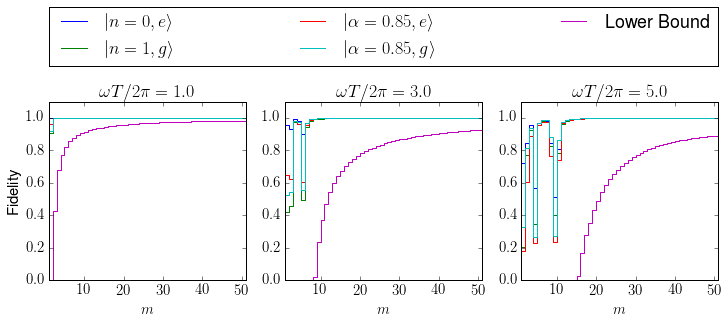

In [13]:
fig, ax = plt.subplots(1, len(T_list), figsize = (4 * len(T_list), 3.2))
labels = [r'$|n=0, e\rangle$', r'$|n=1, g \rangle$',
          r'$|\alpha=0.85, e\rangle$', r'$|\alpha=0.85, g\rangle$']

for i1, T in enumerate(T_list):
    for idx, overlap in enumerate(overlaps):
        ax[i1].step(m_list, overlap[:, i1], lw=1, label=labels[idx])
    ax[i1].step(m_list, np.ones(len(m_list)) - np.array(error[:, i1]), label='Lower Bound')
    ax[i1].set_xlim([1, 51])
    ax[i1].set_ylim([0, 1.1])
    ax[i1].set_xlabel(r'$m$')
    ax[i1].set_title(r'$\omega T / 2\pi = %.1f$' % T)
ax[0].legend(bbox_to_anchor=(0., 1.2, 3.4, .08), loc=3, ncol=3, mode="expand", borderaxespad=0.)
ax[0].set_ylabel('Fidelity');

As can be seen from the figure, there exists a state-independent lower bound which approaches unity as $m\rightarrow\infty$. Surprisingly, the fidelity between the final state which is time-evolved by the total Hamiltonian and its approximant is largely independent of the initial state.

### Calculation of lower bound with Symmetrized Trotter's Formula

In [16]:
overlaps = []
for i in range(len(psi_list)):
    overlaps.append(np.zeros((len(m_list), len(T_list))))

for idx, overlap in enumerate(overlaps):
    for i1, m in enumerate(m_list):
        for i2, T in enumerate(T_list):
            overlap[i1, i2] = fidelity(U_a_sym(H_list, T, m) * psi_list[idx],
                                   U(H, T) * psi_list[idx])

In [17]:
error = np.zeros((len(m_list), len(T_list)))

for i1, m in enumerate(m_list):
    for i2, T in enumerate(T_list):
        error[i1, i2] = norm((U_a_sym(H_list, T, m)- U(H, T)).full(),2)

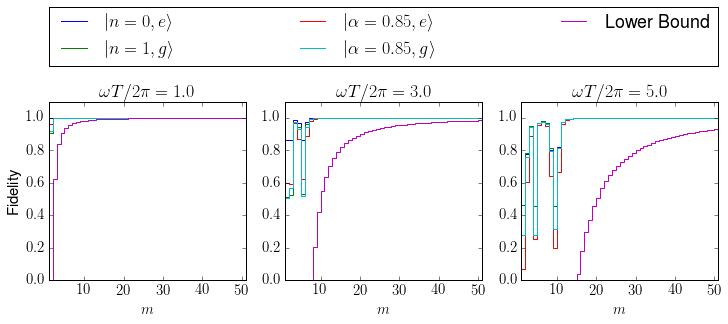

In [18]:
fig, ax = plt.subplots(1, len(T_list), figsize = (4 * len(T_list), 3.2))
labels = [r'$|n=0, e\rangle$', r'$|n=1, g \rangle$',
          r'$|\alpha=0.85, e\rangle$', r'$|\alpha=0.85, g\rangle$']

for i1, T in enumerate(T_list):
    for idx, overlap in enumerate(overlaps):
        ax[i1].step(m_list, overlap[:, i1], lw=1, label=labels[idx])
    ax[i1].step(m_list, np.ones(len(m_list)) - np.array(error[:, i1]), label='Lower Bound')
    ax[i1].set_xlim([1, 51])
    ax[i1].set_ylim([0, 1.1])
    ax[i1].set_xlabel(r'$m$')
    ax[i1].set_title(r'$\omega T / 2\pi = %.1f$' % T)
ax[0].legend(bbox_to_anchor=(0., 1.2, 3.4, .08), loc=3, ncol=3, mode="expand", borderaxespad=0.)
ax[0].set_ylabel('Fidelity');

Moreover, using symmetrized Trotter's formula gives a stronger lower bound, which is close to the actual value of fidelity.